# AlgebraicRelations Workflow → Schema example
### Purpose
This notebook provides an example of how an SQL schema can be directly generated from the definition of a workflow in AlgebraicRelations. Using AlgebraicRelations in this allows for queries to be generated in terms of the processes in the defined workflow.

In [1]:
# We begin by importing necessary libraries
using AlgebraicRelations.DB
using AlgebraicRelations.Queries
using AlgebraicRelations.Workflows 
using AlgebraicRelations.Interface

## Generating Workflow
The workflow is defined by products and processes used within the workflow. The products are any objects that are generated and passed between the processes of the workflow.

In [2]:
# Initialize workflow object
wf = Workflow()

# Add Products to workflow
Files, Images, NeuralNet,
       Accuracy, Metadata = add_products!(wf, [(:Files, :String),
                                               (:Images, :String),
                                               (:NeuralNet, :String),
                                               (:Accuracy, :Float64),
                                               (:Metadata, :String)]);

# Add Processes to workflow
process, split_var, train, evaluate = add_processes!(wf, [(:process, Files, Images),
                                                          (:split, Images, Images⊗Images),
                                                          (:train, NeuralNet⊗Images, NeuralNet⊗Metadata),
                                                          (:evaluate, NeuralNet⊗Images, Accuracy⊗Metadata)]);
# Convert to Schema
TrainingSchema = wf_to_schema(wf)
# Define a constructor for the schema object
TrainDB = SchemaType(TrainingSchema);

In [3]:
print(generate_schema_sql(TrainDB()))

CREATE TABLE evaluate (NeuralNet1 text, Images2 text, Accuracy3 float4, Metadata4 text);
CREATE TABLE process (Files1 text, Images2 text);
CREATE TABLE split (Images1 text, Images2 text, Images3 text);
CREATE TABLE train (NeuralNet1 text, Images2 text, NeuralNet3 text, Metadata4 text);

## Visualizing Workflow
While this visualization currently does not play a role in defining the schema, it can be useful to visually ensure that every piece of the workflow is included.

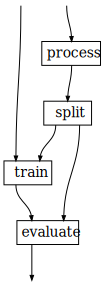

In [4]:
p = @program wf (nn::NeuralNet, file::Files) begin
    images = process(file)
    im_train, im_test = split(images)
    trained_nn, md1 = train(nn, im_train)
    acc, md2 = evaluate(trained_nn, im_test)
    return acc
end;
draw_workflow(p)

### ACSet-defined schema
The backend of AlgebraicRelations stores the schema as an ACSet (generalized database defined in Catlab.jl). The ACSet generated above looks like the following:
```julia
@present TrainingSchema <: TheorySQL begin
    # Tables
    split::Ob
    process::Ob
    train::Ob
    evaluate::Ob
    
    # Columns of tables
    process_1_Files1::Attr(process, String)
    process_2_Images2::Attr(process, String)
    
    split_1_Images1::Attr(split, String)
    split_2_Images2::Attr(split, String)
    split_3_Images3::Attr(split, String)
    
    train_1_NeuralNet1::Attr(train, NeuralNet)
    train_2_Images2::Attr(train, Images)
    train_3_NeuralNet3::Attr(train, NeuralNet)
    train_4_Metadata4::Attr(train, Metadata)
    
    evaluate_1_NeuralNet1::Attr(evaluate, NeuralNet)
    evaluate_2_Images2::Attr(evaluate, Images)
    evaluate_3_Accuracy3::Attr(evaluate, Accuracy)
    evaluate_4_Metadata4::Attr(evaluate, Metadata)
end;
```

## Constructing Queries

Queries are constructed by providing the appropriate Schema, the products to be returned, and the products that are needed in the query. In the `where` statement, we define the types of each product (based on the workflow definition). We then use the processes in the workflow along with comparison operators to construct a query based on relationships between products.

The following query will create a query which generates a table containing all neural network structures, sets of images they were trained, and their accuracies on the test images which performed higher than some base accuracy (`_base_acc`).

SELECT t1.Images2 AS im_train, t1.NeuralNet1 AS nn, t2.Images2 AS im_test, t2.Accuracy3 AS acc
FROM train AS t1, evaluate AS t2
WHERE t2.NeuralNet1=t1.NeuralNet3 AND t2.Accuracy3>=$1

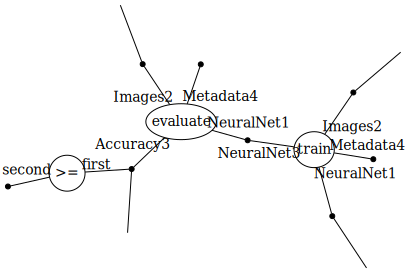

In [5]:
q = @query TrainDB() (im_train, nn, im_test, acc) where (im_train::Images, im_test::Images, nn::NeuralNet,
                                     nn_trained::NeuralNet, acc::Accuracy, md::Metadata,
                                     md2::Metadata, _base_acc::Accuracy) begin
    train(nn, im_train, nn_trained, md)
    evaluate(nn_trained, im_test, acc, md2)
    >=(acc, _base_acc)
end
print(to_sql(q))
draw_query(q)

## Querying a PostgreSQL database
AlgebraicRelations also provides an interface with `LibPQ.jl` which allows us to query a database directly using the query object. Below is an example of the use of this interface.

In [6]:
conn = Connection("dbname=test_wf");

In [7]:
statement1 = prepare(conn,q);

In [8]:
execute(statement1, [0.7])

,im_train,nn,im_test,acc
,String?,String?,String?,Float32?
1,im_tr_1,nn_struc/struct1,im_te_2,0.95
2,im_tr_1,nn_struc/struct1,im_te_1,0.9
3,im_tr_2,nn_struc/struct2,im_te_2,0.8
4,im_tr_2,nn_struc/struct2,im_te_1,0.75
5,im_tr_1,nn_struc/struct1,im_te_2,0.75
